## Import Libraries

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# Getting file path
import os

# For regex
import re

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical

# specifically for cnn
from keras.layers import Dropout, Flatten,Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
 
import tensorflow as tf
import random as rn

# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
import cv2                  
import numpy as np  
from tqdm import tqdm               
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

## Data Preparation

### To get the training and validation set from the images

In [3]:
X=[]
Z=[]
IMG_SIZE=150

In [4]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label = flower_type
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        X.append(np.array(img))
        Z.append(str(label))

In [5]:
def get_dir_label(DIR):
    dir_dict = {}
    for class_label in os.listdir(DIR):
        if re.match(r'^\w', class_label):
            flower_name = class_label.capitalize()
            flower_dir = DIR +'/'+ class_label
            dir_dict[flower_name] = flower_dir
    return dir_dict

In [13]:
# Remove .DS store file
path = "./flowers"

def rem_filename(DIR):
    for filename in os.listdir(DIR):
#         if filename.endswith(".png"):
        if re.match(r'^.DS', filename):
#             os.remove(DIR+"/"+filename)
            print(filename)
            print("File removed!")
            
for dir_list in os.listdir(path):
    if re.match(r'^\w', dir_list):
        folder = path+"/"+dir_list
        rem_filename(folder)

In [14]:
label= get_dir_label('./flowers')
for k,v in label.items():
    make_train_data(k,v)

100%|███████████████████████████████████████████| 95/95 [00:14<00:00,  6.49it/s]


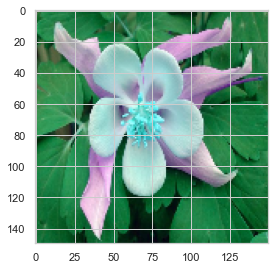

In [259]:
plt.imshow(X[0]/255)

### Visualizing Some Random Images

In [236]:
print(label)

{'Columbine': './flower_image/flowers/columbine', 'Frangipani': './flower_image/flowers/frangipani', 'Marigold': './flower_image/flowers/marigold', 'Daisy': './flower_image/flowers/daisy', 'Lotus': './flower_image/flowers/lotus', 'Tigerlily': './flower_image/flowers/tigerlily', 'Gazania': './flower_image/flowers/gazania', 'Globe flower': './flower_image/flowers/globe flower', 'Thorn apple': './flower_image/flowers/thorn apple', 'Black eyed susan': './flower_image/flowers/black eyed susan', 'Osteospermum': './flower_image/flowers/osteospermum', 'Sunflower': './flower_image/flowers/sunflower'}


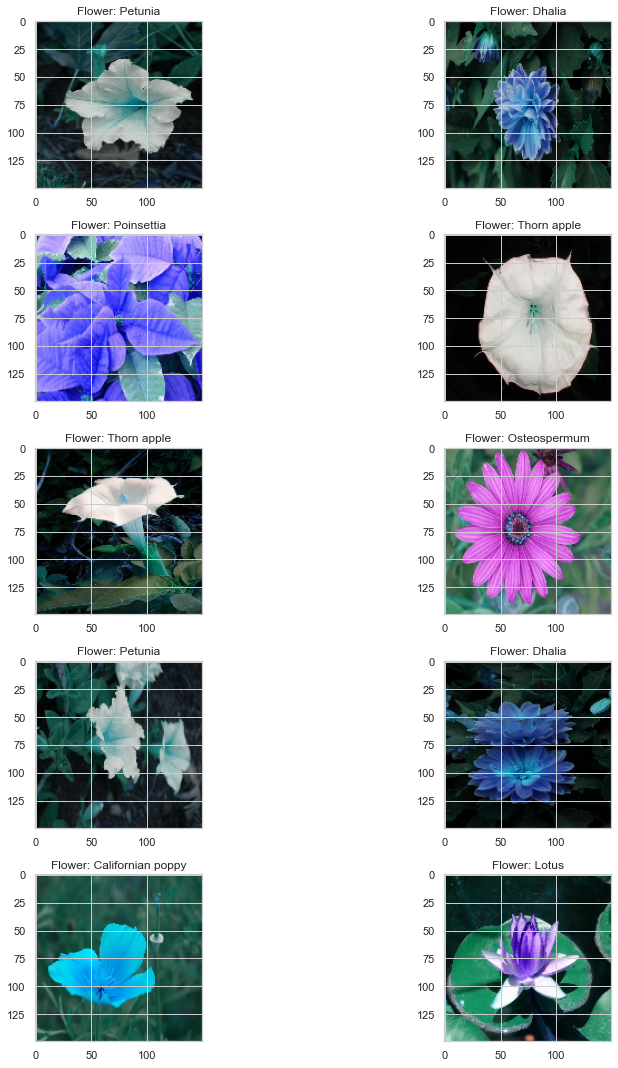

In [15]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('Flower: '+Z[l])
        
plt.tight_layout()

### Normalization and One Hot Encoding

In [16]:
# Normalize data
le=LabelEncoder()
Y=le.fit_transform(Z)
Y=to_categorical(Y,len(Z))
X=np.array(X)
X=X/255

## Split Data for Training and Test

### Splitting into Training and Validation

In [17]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

### Setting the Random Seeds

In [18]:
# To resolve randomness of the model result
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

## Building the Model

### Building ConvNet Model

In [31]:
# modelling starts using a CNN.
# Uses RELU and Softmax for activation function

model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3,3),padding = 'Same',activation ='relu', input_shape = (150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters = 32, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
 
model.add(Conv2D(filters =64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same',activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(len(Z), activation = "softmax"))

### Using LR Annealer

In [32]:
batch_size=32
epochs=50

from keras.callbacks import ReduceLROnPlateau
red_lr= ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.1)

### Data Augmentation to Prevent Overfitting

In [33]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.25, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

## Compilation

### Compiling the Keras Model & Summary

In [34]:
model.compile(optimizer=Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])

In [35]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 75, 75, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 37, 37, 96)        55392     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 18, 18, 96)      

## Fitting on the Training set and making prediction on Validation set

In [36]:
History = model.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_test,y_test),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size)


Epoch 1/50
14/14 [==============================] - 81s 6s/step - loss: 4.7081 - accuracy: 0.0526 - val_loss: 3.3165 - val_accuracy: 0.1699
Epoch 2/50
14/14 [==============================] - 78s 6s/step - loss: 3.2660 - accuracy: 0.0625 - val_loss: 3.0143 - val_accuracy: 0.0955
Epoch 3/50
14/14 [==============================] - 81s 6s/step - loss: 3.0773 - accuracy: 0.0893 - val_loss: 2.9258 - val_accuracy: 0.0955
Epoch 4/50
14/14 [==============================] - 81s 6s/step - loss: 2.9647 - accuracy: 0.1171 - val_loss: 2.7418 - val_accuracy: 0.1741
Epoch 5/50
14/14 [==============================] - 82s 6s/step - loss: 2.7443 - accuracy: 0.1850 - val_loss: 2.4561 - val_accuracy: 0.2251
Epoch 6/50
14/14 [==============================] - 81s 6s/step - loss: 2.4772 - accuracy: 0.2296 - val_loss: 2.3079 - val_accuracy: 0.2654
Epoch 7/50
14/14 [==============================] - 77s 5s/step - loss: 2.3454 - accuracy: 0.2670 - val_loss: 2.0282 - val_accuracy: 0.3376
Epoch 8/50
14/14 [==

## 4. Evaluation

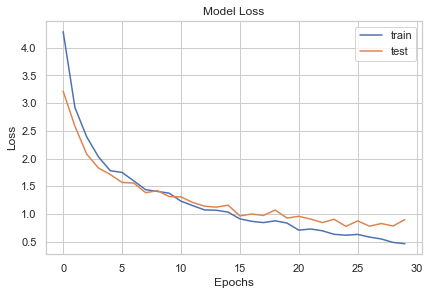

The loss value is:  0.46301785111427307


In [29]:
plt.plot(History.history['loss'])
plt.plot(History.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The loss value is: ', History.history['loss'][-1])

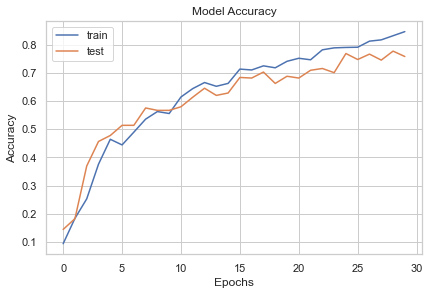

The accuracy of the model is:  84 %


In [30]:
plt.plot(History.history['accuracy'])
plt.plot(History.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

print('The accuracy of the model is: ', int(History.history['accuracy'][-1] * 100), '%')

## 5. Visualizing Predictions on the Validation Set

In [61]:
# getting predictions on val set.
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

15/15 [==============================] - 7s 448ms/step


In [62]:
# now storing some properly as well as misclassified indexes'.
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
#     if(len(prop_class)==8):
#         break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
#     if(len(mis_class)==8):
#         break


In [63]:
print(len(prop_class))
print(len(mis_class))

346
103


## Result

### CORRECTLY CLASSIFIED FLOWER IMAGES

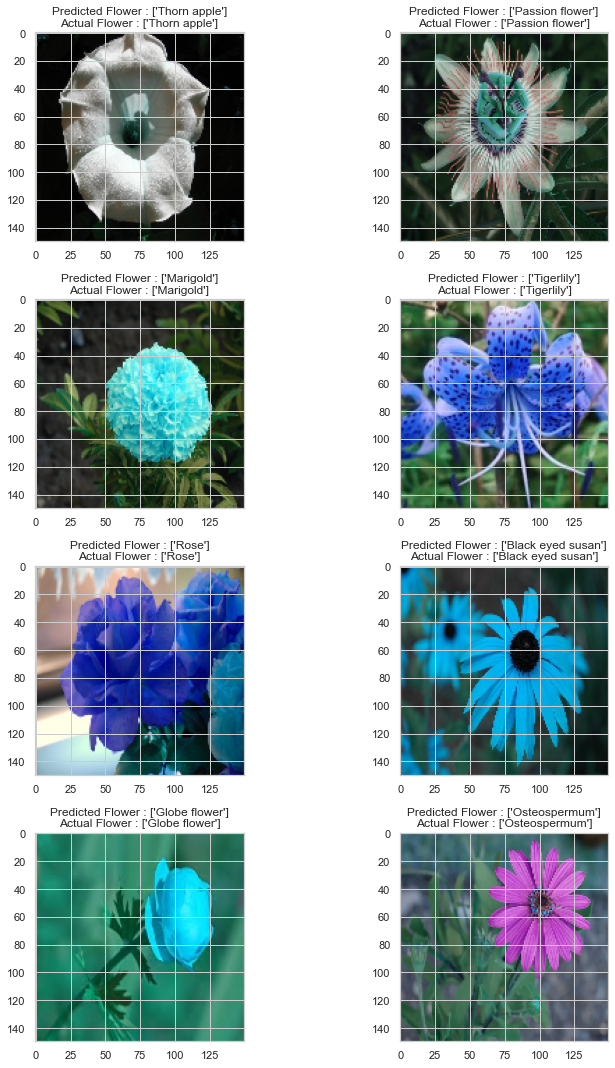

In [30]:
# warnings.filterwarnings('always')
# warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[prop_class[count]])])))
        plt.tight_layout()
        count+=1
        

### MISCLASSIFIED IMAGES OF FLOWERS

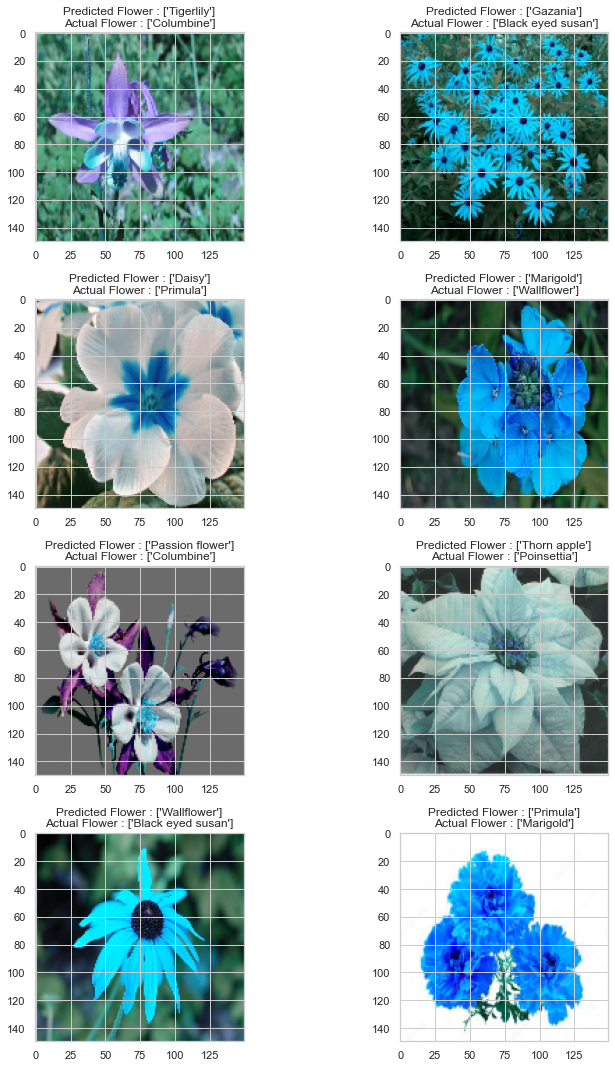

In [31]:
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range(4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+"\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax(y_test[mis_class[count]])])))
        plt.tight_layout()
        count+=1